## 1. Objective
This case requires to develop a customer segmentation to understand customers behavior and sepparate them in different groups or cluster according to their preferences, and once the division is done, this information can be given to marketing team so they can plan the strategy accordingly.

### Data Description :
The sample Dataset summarizes the usage behavior of about 200 active customers during the last 3 months. The file is at a customer level with 5 behavioral variables.

### Attribute Information :
Following is the Data Dictionary for customer dataset :-

CustomerID : Unique ID assigned to the customer

Gender :Gender of the customer

Age : Age of the customer

Annual Income (k$) : Annual Income of the customee

Spending Score : Score assigned by the mall based on customer behavior and spending nature

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
# clustering algorithms
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Data Collection and Analysis

In [3]:
data = pd.read_csv('Mall_Customers.csv')
df = data.copy()

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.shape

(200, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [8]:
df.drop('CustomerID', axis=1, inplace=True) # CustomerID is a useless feature.

In [9]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [10]:
df.replace({'Male':0, 'Female':1}, inplace=True)

In [11]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Gender                  200 non-null    int64
 1   Age                     200 non-null    int64
 2   Annual Income (k$)      200 non-null    int64
 3   Spending Score (1-100)  200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


In [13]:
numerical_features = [col for col in df.columns if df[col].dtypes != 'O']
discrete_features = [col for col in numerical_features if len(df[col].unique()) < 10 ]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features]
categorical_features = [col for col in df.columns if df[col].dtype == 'O']

print("Total Number of Numerical Columns : ",len(numerical_features))
print("Number of discrete features : ",len(discrete_features))
print("No of continuous features are : ", len(continuous_features))
print("Number of categorical features : ",len(categorical_features))

Total Number of Numerical Columns :  4
Number of discrete features :  1
No of continuous features are :  3
Number of categorical features :  0


We have converted Gender to numerical column so no. of categorical features = 0

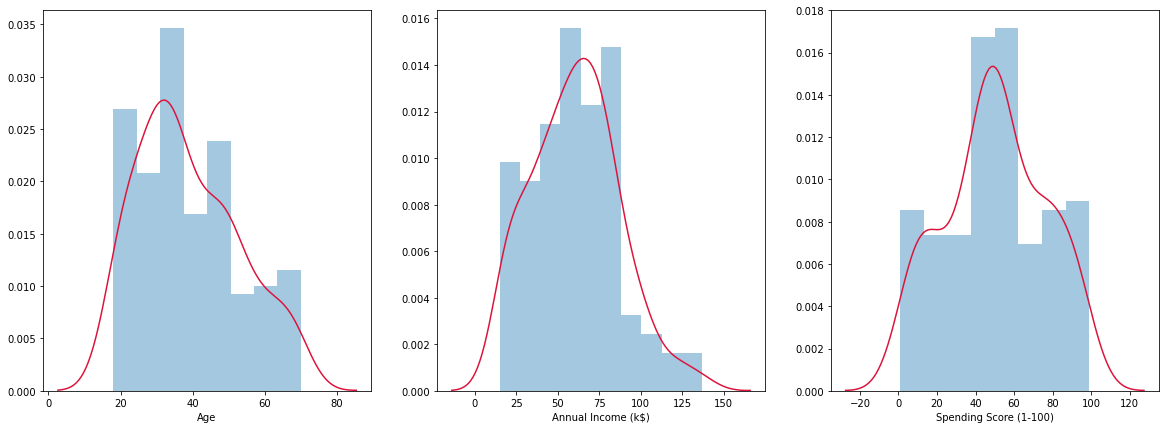

In [14]:
plt.figure(figsize=(20,7))
pos = 1
for i, feature in enumerate(continuous_features):
    plt.subplot(1 , 3 , pos)
    ax = sns.distplot(df[feature])
    ax.lines[0].set_color('crimson')
    pos = pos + 1

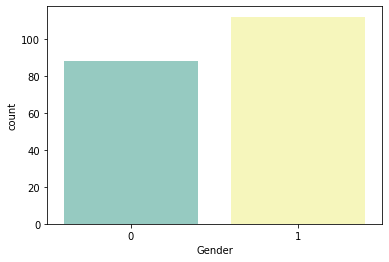

In [15]:
sns.countplot(x='Gender', data=df, palette="Set3")

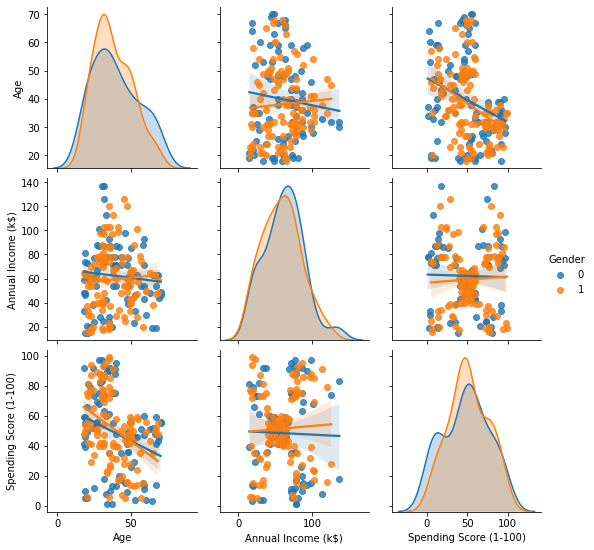

In [16]:
sns.pairplot(df, hue='Gender', kind='reg')

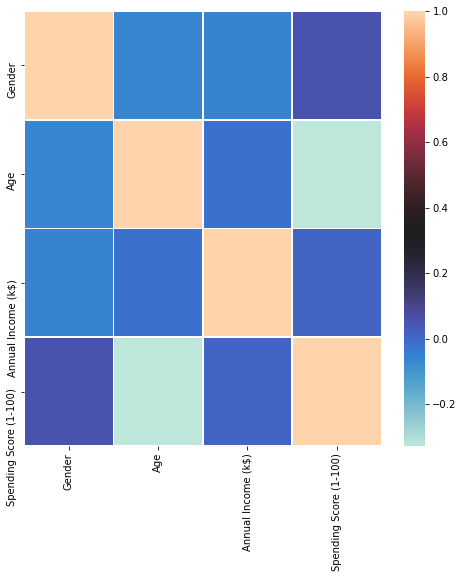

In [17]:
corr = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cmap="icefire", linewidths=.5)

In [18]:
corr

,Gender,Age,Annual Income (k$),Spending Score (1-100)
Gender,1.000000,-0.060867,-0.056410,0.058109
Age,-0.060867,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.056410,-0.012398,1.000000,0.009903
Spending Score (1-100),0.058109,-0.327227,0.009903,1.000000


None of the features are highly or even mildly correlated

## Model Development

In this step we'll apply various clustering algorithms and check which algorithm is best for our dataset. We'r going to use below algorithms.

* Kmeans Clustering
* Agglomerative Clustering
* GaussianMixture Model based clustering
* DBSCAN Clustering

## KMeans

#### Hyperparameter tuning for KMeans
To find the best K value there are many techniques we can use.

1. Elbow Method: The elbow method finds the value of the optimal number of clusters using the total within-cluster sum of square values.
2. Average silhouette method : It is a measure of how well each data point fits its corresponding cluster. This method evaluates the quality of clustering. As a general rule, a high average silhouette width denotes better clustering output.
3. Gap statistic method : It is a measure of the value of gap statistics. Gap statistics is the difference between the total intracluster changes for various values of k compared to their expected values. The optimal number of clusters is the value that maximizes the value of gap statistics.
* Here we'll use Elbow Method to find the best K Value.

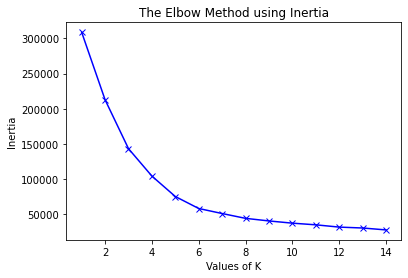

In [19]:
inertia = []
range_val = range(1,15)
for i in range_val:
    kmean = KMeans(n_clusters=i)
    kmean.fit_predict(df)
    inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

The elbow/best value of K is not distinguishable/clearly visible. It is either 4,5 or 6.
* In times like this we should use Silhouette Score to find the the optimal value of K

In [20]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df)
                for k in range(1, 15)]
silhouette_scores = [silhouette_score(df, model.labels_)
                     for model in kmeans_per_k[1:]]

In [21]:
silhouette_scores

[0.29307334005502633,
 0.383798873822341,
 0.4052954330641215,
 0.44424291275274114,
 0.45205475380756527,
 0.43479758148661335,
 0.4294563708430266,
 0.4140946137007603,
 0.3767261126586057,
 0.3730782399224409,
 0.35165215578581555,
 0.34804338908053234,
 0.34808945180281975]

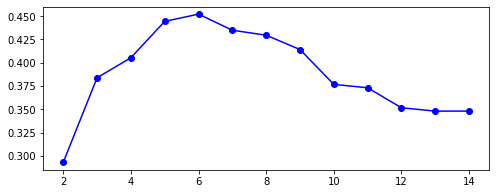

In [22]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 15), silhouette_scores, "bo-")

From the above plot we can clearly see that silhouette_score is maximum for K = 6 and that is what we need.

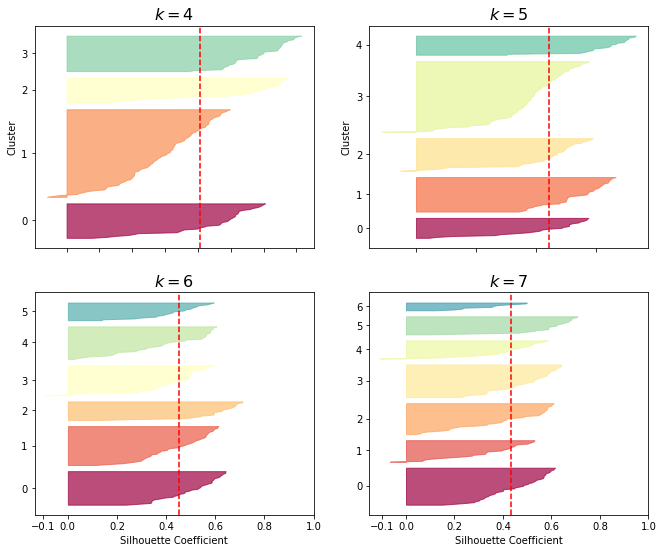

In [23]:
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(11, 9))

for k in (4, 5, 6, 7):
    plt.subplot(2, 2, k - 3)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(df, y_pred)

    padding = len(df) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (4, 5):
        plt.ylabel("Cluster")
    
    if k in (6, 7):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

In [24]:
kmeans_model = KMeans(n_clusters=6)
kmeans_clusters = kmeans_model.fit_predict(df)

In [25]:
kmeans_clusters

array([5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4,
       5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 1, 4, 1, 2,
       5, 4, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2,
       2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 3, 2, 3, 0, 3, 0, 3, 0, 3,
       2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3])

## Agglomerative Clustering

In [26]:
agglo_model = AgglomerativeClustering(linkage="ward",n_clusters=6)
agglomerative_clusters = agglo_model.fit_predict(df)

In [27]:
agglo_model.labels_

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 5, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 5,
       4, 5, 1, 5, 5, 5, 1, 5, 5, 1, 1, 1, 1, 1, 5, 1, 1, 5, 1, 1, 1, 5,
       1, 1, 5, 5, 1, 1, 1, 1, 1, 5, 1, 1, 5, 1, 1, 1, 1, 1, 5, 1, 1, 5,
       1, 1, 1, 5, 1, 1, 1, 5, 1, 5, 1, 5, 5, 1, 1, 5, 1, 5, 1, 1, 1, 1,
       1, 5, 1, 5, 5, 5, 1, 1, 1, 1, 5, 1, 1, 2, 5, 2, 0, 2, 0, 2, 0, 2,
       5, 2, 0, 2, 0, 2, 0, 2, 0, 2, 5, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2], dtype=int64)

## GaussianMixture Model based clustering

In [28]:
GaussianMixture_model = GaussianMixture(n_components=6)
gmm_clusters = GaussianMixture_model.fit_predict(df)

In [29]:
gmm_clusters

array([1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4, 1, 4, 1, 0, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 0,
       1, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0,
       2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 5, 0, 5, 2, 5, 3, 5, 3, 5,
       0, 5, 3, 5, 3, 5, 3, 5, 3, 5, 0, 5, 3, 5, 2, 5, 3, 5, 3, 5, 3, 5,
       3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5,
       3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5,
       3, 5], dtype=int64)

## DBSCAN Clustering

In [30]:
model_dbscan = DBSCAN(eps=3, min_samples=17)
dbscan_clusters = model_dbscan.fit_predict(df)

To compare which clustering algorithm is best for our model, we use various cluster validity indices.

1. Dunn Index
2. Davies Bouldin Index
3. Silhouette Score
4. Calinski - Harabasz Index

    * "algorithms that produce clusters with high Dunn index are more desirable" -Wikipedia
    * "Objects with a high silhouette value are considered well clustered" -Wikipedia
    * "clustering algorithm that produces a collection of clusters with the smallest Davies–Bouldin index is considered the best algorithm" -Wikipedia

    * Here we'll use silhouette score method to choose the best clustering algorithm

In [31]:
def silhouette_method(df,algo,y_pred):
    print('==========================================================================')
    print('Clustering ',algo," : silhouette score : ",silhouette_score(df,y_pred) )


silhouette_method(df,' : KMeans',kmeans_clusters)
silhouette_method(df,' : Agglomerative',agglomerative_clusters)
silhouette_method(df,' : GaussianMixture',gmm_clusters)
print('===========================================================================')

Clustering   : KMeans  : silhouette score :  0.45205475380756527
Clustering   : Agglomerative  : silhouette score :  0.4428008535928764
Clustering   : GaussianMixture  : silhouette score :  0.44554665984545394


* From the above analysis,we saw that "K-Means" algorithm has high silhouette score as compared to others. So we'll apply K-Means algorithm for our model.

### Cluster Visualization

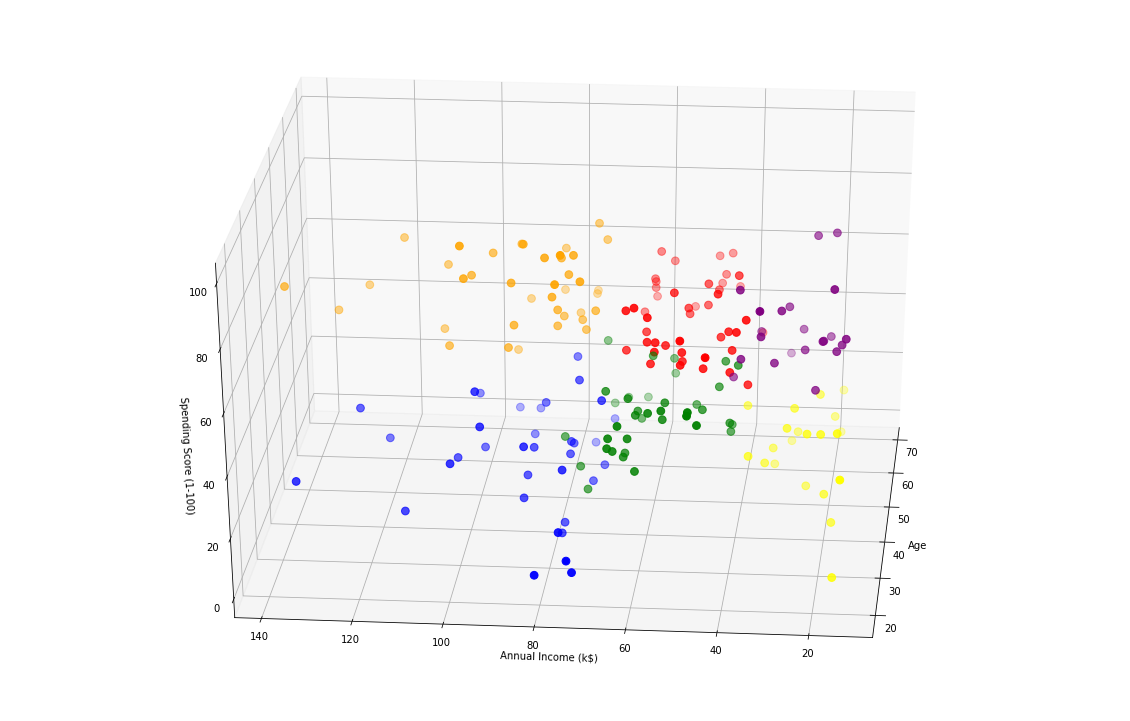

In [32]:
df["label"] = kmeans_clusters

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
fig = plt.figure(figsize=(20,13))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Age[df.label == 0], df["Annual Income (k$)"][df.label == 0], df["Spending Score (1-100)"][df.label == 0], c='blue', s=60)
ax.scatter(df.Age[df.label == 1], df["Annual Income (k$)"][df.label == 1], df["Spending Score (1-100)"][df.label == 1], c='red', s=60)
ax.scatter(df.Age[df.label == 2], df["Annual Income (k$)"][df.label == 2], df["Spending Score (1-100)"][df.label == 2], c='green', s=60)
ax.scatter(df.Age[df.label == 3], df["Annual Income (k$)"][df.label == 3], df["Spending Score (1-100)"][df.label == 3], c='orange', s=60)
ax.scatter(df.Age[df.label == 4], df["Annual Income (k$)"][df.label == 4], df["Spending Score (1-100)"][df.label == 4], c='purple', s=60)
ax.scatter(df.Age[df.label == 5], df["Annual Income (k$)"][df.label == 5], df["Spending Score (1-100)"][df.label == 5], c='yellow', s=60)
ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.show()


### Lets use only two features Annual Income (k$) and Spending Score (1-100),
so that we can visualize everything properly in 2D.

In [33]:
df1 = df[['Annual Income (k$)','Spending Score (1-100)']]
df1.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Annual Income (k$)      200 non-null    int64
 1   Spending Score (1-100)  200 non-null    int64
dtypes: int64(2)
memory usage: 3.2 KB


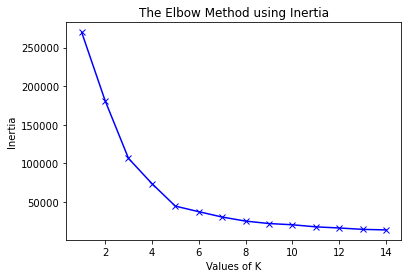

In [35]:
inertia1 = []
range_val = range(1,15)
for i in range_val:
    kmean = KMeans(n_clusters=i)
    kmean.fit_predict(df1)
    inertia1.append(kmean.inertia_)
plt.plot(range_val,inertia1,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

### Here the elbow is clearly visible i.e K = 5 is the best value.

Lets check silhouette scores too

In [36]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df1)
                for k in range(1, 15)]
silhouette_scores1 = [silhouette_score(df1, model.labels_)
                     for model in kmeans_per_k[1:]]

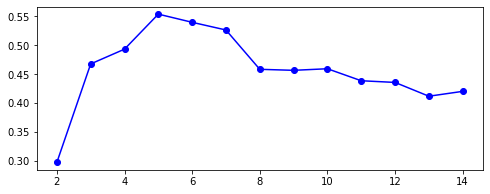

In [37]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 15), silhouette_scores1, "bo-")

This graph confirms that K = 5 is the best value and there are five clusters.

In [38]:
kmeans_model_2D = KMeans(n_clusters=5, random_state=42)
kmeans_clusters_2D = kmeans_model_2D.fit_predict(df1)

In [39]:
y = kmeans_clusters_2D
y

array([2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 0,
       2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 4, 0, 4, 1, 4, 1, 4,
       0, 4, 1, 4, 1, 4, 1, 4, 1, 4, 0, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4])

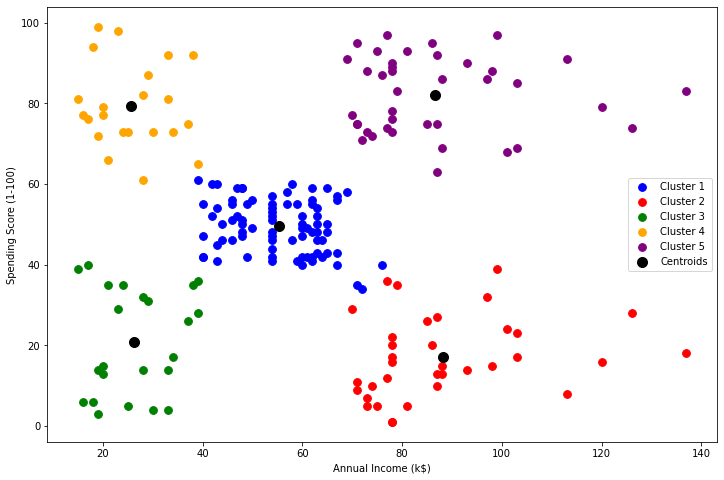

In [40]:
df1["label"] = kmeans_clusters_2D

 
plt.figure(figsize=(12,8))

plt.scatter(df1["Annual Income (k$)"][df1.label == 0], df1["Spending Score (1-100)"][df1.label == 0], c='blue', s=60, label='Cluster 1')
plt.scatter(df1["Annual Income (k$)"][df1.label == 1], df1["Spending Score (1-100)"][df1.label == 1], c='red', s=60, label='Cluster 2')
plt.scatter(df1["Annual Income (k$)"][df1.label == 2], df1["Spending Score (1-100)"][df1.label == 2], c='green', s=60, label='Cluster 3')
plt.scatter(df1["Annual Income (k$)"][df1.label == 3], df1["Spending Score (1-100)"][df1.label == 3], c='orange', s=60, label='Cluster 4')
plt.scatter(df1["Annual Income (k$)"][df1.label == 4], df1["Spending Score (1-100)"][df1.label == 4], c='purple', s=60, label='Cluster 5')
plt.scatter(kmeans_model_2D.cluster_centers_[:,0], kmeans_model_2D.cluster_centers_[:,1], s=100, c='black', label='Centroids')

plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.show()